In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax import random

import pandas as pd
import matplotlib.pyplot as plt

import time
import sys
import os

p = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if p not in sys.path:
    sys.path.append(p)

from collocation import compute_weights, lagrange_derivative
#from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
#from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
#from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
# RELOADING MODULES
import importlib
import neural_net_jax
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

import data_generation
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

# ----------------- diffrax code -----------------
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.nn as jnn
import jax.random as jr
import optax  # https://github.com/deepmind/optax


In [2]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.05
ode_type, params = "sinusoidal_oscillator", {"A": 0.25}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [24]:
u_noisy = np.atleast_2d(y_noisy).T
r, c = u_noisy.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 200; c : 1
r : 200; c : 1


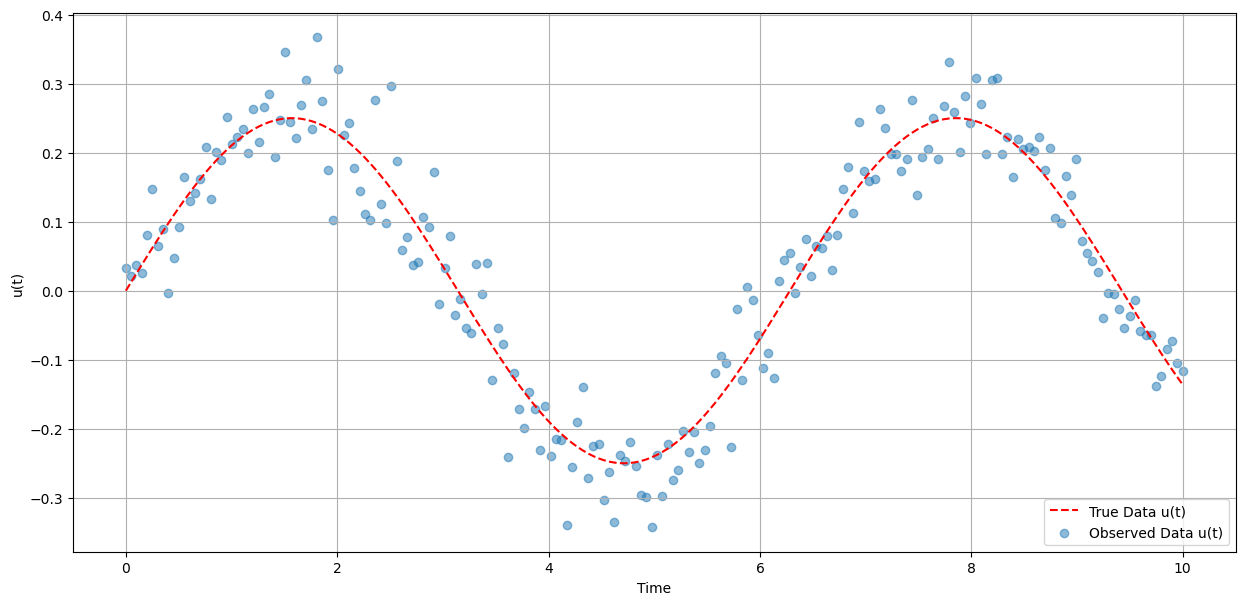

In [25]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')

plt.plot(t, y, 'r--', label='True Data u(t)') 
plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `Regular JAX Odeint training`

In [36]:
importlib.reload(neural_net_jax)
NeuralODE_JAX = neural_net_jax.NeuralODE

In [63]:
y_pred_results = {}
n = 50

layer_widths = [1, 64, 64, 1]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)

state = node_model.create_train_state(rng, learning_rate)
state = node_model.train(state, t[:n], u_noisy[:n], y[0], num_epochs = 1000)
#state = node_model.train(state, t, u_noisy, y[0], num_epochs = 1000)

Epoch 0, Loss: 0.05269615838690093
Epoch 100, Loss: 0.015177345691169184
Epoch 200, Loss: 0.013581930994505144
Epoch 300, Loss: 0.012256611517241098
Epoch 400, Loss: 0.011138870448641794
Epoch 500, Loss: 0.010180989636299409
Epoch 600, Loss: 0.009352441467086116
Epoch 700, Loss: 0.008632911991378202
Epoch 800, Loss: 0.008007674173890473
Epoch 900, Loss: 0.007465154249926506


In [64]:
y_train_pred = node_model.neural_ode(state.params, y[0], t, state)
y_test_pred = node_model.neural_ode(state.params, y_test[0], t_test, state)

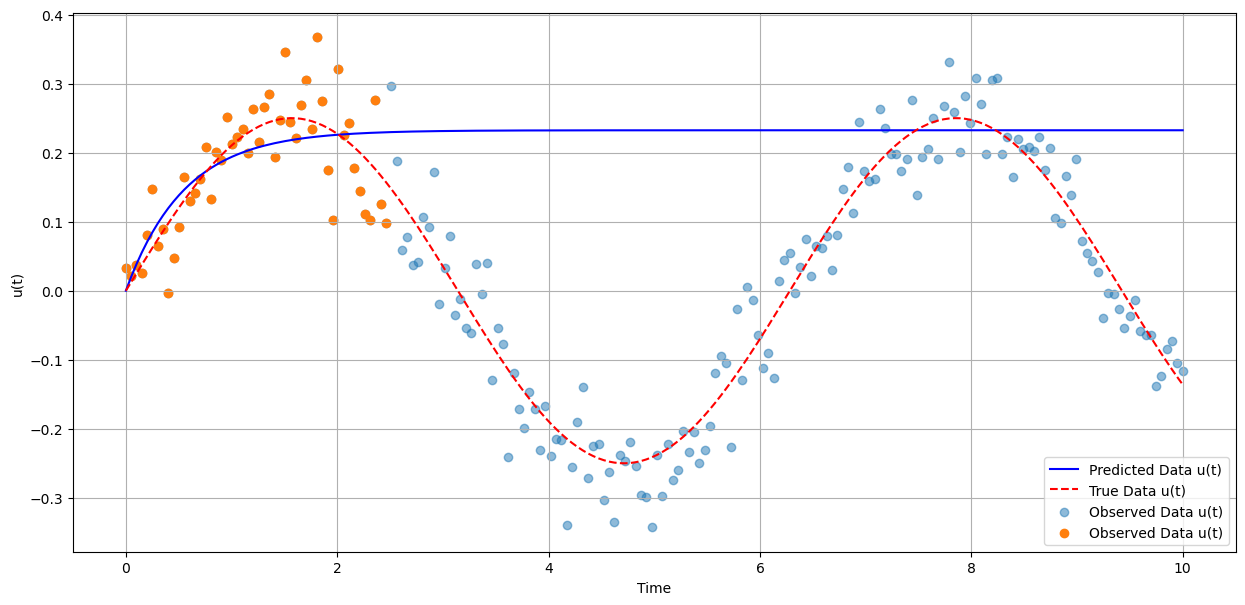

In [65]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
#plt.plot(t, y_train_pred, 'b', label='Predicted Solution u(t)')
#plt.plot(t_test_ho[N-1:], result['y_test_pred'].T, 'b', label='Predicted Solution u(t')

plt.plot(t, y_train_pred, 'b', label='Predicted Data u(t)') 
plt.plot(t, y, 'r--', label='True Data u(t)') 
plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 
plt.scatter(t[:n], u_noisy[:n], label='Observed Data u(t)', alpha=1) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

## `Diffrax`

In [3]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

class NODETrainer:
    def __init__(self, data_size, width_size, depth, lr, steps, seed=5678):
        self.key = jr.PRNGKey(seed)
        model_key = jr.split(self.key, 1)[0]
        self.model = NeuralODE(data_size, width_size, depth, key=model_key)
        self.lr = lr
        self.steps = steps
        self.optimizer = optax.adabelief(self.lr)
        self.opt_state = self.optimizer.init(eqx.filter(self.model, eqx.is_inexact_array))

    @eqx.filter_value_and_grad
    def grad_loss(self, model, ti, yi):
        y_pred = model(ti, yi[0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(self, ti, yi, model, opt_state):
        loss, grads = self.grad_loss(model, ti, yi)
        updates, opt_state = self.optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    def train(self, ts, ys, print_every=100, plot=True):
        length_size, data_size = ys.shape

        for step in range(self.steps):
            start = time.time()
            loss, self.model, self.opt_state = self.make_step(ts, ys, self.model, self.opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == self.steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

        if plot:
            plt.plot(ts, ys[:, 0], c="dodgerblue", label="Real")
            plt.plot(ts, ys[:, 1], c="dodgerblue")
            model_y = self.model(ts, ys[0])
            plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
            plt.plot(ts, model_y[:, 1], c="crimson")
            plt.legend()
            plt.tight_layout()
            plt.savefig("neural_ode.png")
            plt.show()

        return ts, ys, self.model

In [4]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.05
ode_type, params = "sinusoidal_oscillator", {"A": 0.25}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

Step: 0, Loss: 36.6136356830612, Computation time: 0.36064910888671875
Step: 100, Loss: 36.6136356830612, Computation time: 0.0005908012390136719
Step: 200, Loss: 36.6136356830612, Computation time: 0.0006330013275146484
Step: 300, Loss: 36.6136356830612, Computation time: 0.0005908012390136719
Step: 400, Loss: 36.6136356830612, Computation time: 0.0005710124969482422
Step: 500, Loss: 36.6136356830612, Computation time: 0.0006718635559082031
Step: 600, Loss: 36.6136356830612, Computation time: 0.0006120204925537109
Step: 700, Loss: 36.6136356830612, Computation time: 0.0005750656127929688
Step: 800, Loss: 36.6136356830612, Computation time: 0.0005810260772705078
Step: 900, Loss: 36.6136356830612, Computation time: 0.0005838871002197266
Step: 1000, Loss: 36.6136356830612, Computation time: 0.0005729198455810547
Step: 1100, Loss: 36.6136356830612, Computation time: 0.000576019287109375
Step: 1200, Loss: 36.6136356830612, Computation time: 0.0009410381317138672
Step: 1300, Loss: 36.613635

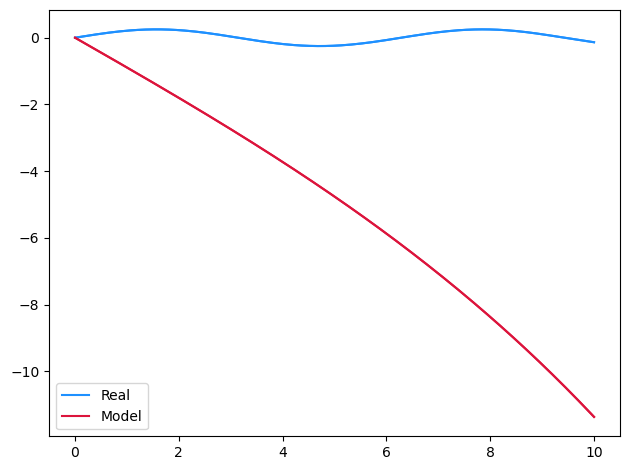

(array([ 0.        ,  0.05025126,  0.10050251,  0.15075377,  0.20100503,
         0.25125628,  0.30150754,  0.35175879,  0.40201005,  0.45226131,
         0.50251256,  0.55276382,  0.60301508,  0.65326633,  0.70351759,
         0.75376884,  0.8040201 ,  0.85427136,  0.90452261,  0.95477387,
         1.00502513,  1.05527638,  1.10552764,  1.15577889,  1.20603015,
         1.25628141,  1.30653266,  1.35678392,  1.40703518,  1.45728643,
         1.50753769,  1.55778894,  1.6080402 ,  1.65829146,  1.70854271,
         1.75879397,  1.80904523,  1.85929648,  1.90954774,  1.95979899,
         2.01005025,  2.06030151,  2.11055276,  2.16080402,  2.21105528,
         2.26130653,  2.31155779,  2.36180905,  2.4120603 ,  2.46231156,
         2.51256281,  2.56281407,  2.61306533,  2.66331658,  2.71356784,
         2.7638191 ,  2.81407035,  2.86432161,  2.91457286,  2.96482412,
         3.01507538,  3.06532663,  3.11557789,  3.16582915,  3.2160804 ,
         3.26633166,  3.31658291,  3.36683417,  3.4

In [5]:
# Example usage
key = jr.PRNGKey(5678)

trainer = NODETrainer(data_size=1, width_size=64, depth=3, lr=3e-3, steps=10000)
trainer.train(t, y)

In [6]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

class NODETrainer:
    def __init__(self, data_size, width_size, depth, lr, steps, batch_size, seed=5678):
        self.key = jr.PRNGKey(seed)
        model_key = jr.split(self.key, 1)[0]
        self.model = NeuralODE(data_size, width_size, depth, key=model_key)
        self.lr = lr
        self.steps = steps
        self.batch_size = batch_size
        self.optimizer = optax.adabelief(self.lr)
        self.opt_state = self.optimizer.init(eqx.filter(self.model, eqx.is_inexact_array))

    def generate_data(self, num_datasets, N, noise_level, ode_type, params, start_time, end_time, spacing_type, key):
        keys = jr.split(key, num_datasets)
        data = [generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, jr.uniform(k, (2,), minval=-0.6, maxval=1.0)) for k in keys]
        ts, ys, ys_noisy, true_derivatives = zip(*data)
        return ts[0], jnp.stack(ys), jnp.stack(ys_noisy), jnp.stack(true_derivatives)

    @eqx.filter_value_and_grad
    def grad_loss(self, model, ti, yi):
        def single_loss(y):
            return jnp.mean((yi - model(ti, y)) ** 2)
        return single_loss

    @eqx.filter_jit
    def make_step(self, ti, yi, model, opt_state):
        loss, grads = self.grad_loss(model, ti, yi)
        updates, opt_state = self.optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    def dataloader(self, arrays, batch_size, *, key):
        dataset_size = arrays[0].shape[0]
        assert all(array.shape[0] == dataset_size for array in arrays)
        indices = jnp.arange(dataset_size)
        while True:
            perm = jr.permutation(key, indices)
            (key,) = jr.split(key, 1)
            start = 0
            end = batch_size
            while end < dataset_size:
                batch_perm = perm[start:end]
                yield tuple(array[batch_perm] for array in arrays)
                start = end
                end = start + batch_size

    def train(self, num_datasets, N, noise_level, ode_type, params, start_time, end_time, spacing_type, print_every=100, plot=True):
        data_key, model_key, loader_key = jr.split(self.key, 3)
        
        ts, ys, ys_noisy, true_derivatives = self.generate_data(
            num_datasets, N, noise_level, ode_type, params, start_time, end_time, spacing_type, key=data_key)
        length_size, data_size = ys.shape[1:]

        _ts = ts
        _ys = ys_noisy

        for step, (yi,) in zip(
            range(self.steps), self.dataloader((_ys,), self.batch_size, key=loader_key)
        ):
            start = time.time()
            loss, self.model, self.opt_state = self.make_step(_ts, yi, self.model, self.opt_state)
            end = time.time()
            print("step")
            if (step % print_every) == 0 or step == self.steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

        if plot:
            plt.plot(ts, ys[:, 0], c="dodgerblue", label="Real")
            plt.plot(ts, ys[:, 1], c="dodgerblue")
            model_y = self.model(ts, ys[0])
            plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
            plt.plot(ts, model_y[:, 1], c="crimson")
            plt.legend()
            plt.tight_layout()
            plt.savefig("neural_ode.png")
            plt.show()

        return ts, ys, self.model

In [7]:
# Example usage
N = 50
noise_level = 0.1
ode_type = 'harmonic_oscillator'
params = {'omega_squared': 1.0}
start_time = 0.0
end_time = 10.0
spacing_type = 'uniform'
num_datasets = 10

trainer = NODETrainer(data_size=2, width_size=64, depth=2, lr=3e-3, steps=1000, batch_size=32)
trainer.train(num_datasets, N, noise_level, ode_type, params, start_time, end_time, spacing_type)

# ts, ys, ys_noisy, true_derivatives = trainer.generate_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, key=jr.PRNGKey(1))

KeyboardInterrupt: 

In [100]:
data_key, model_key, loader_key = jr.split(jr.PRNGKey(1), 3)

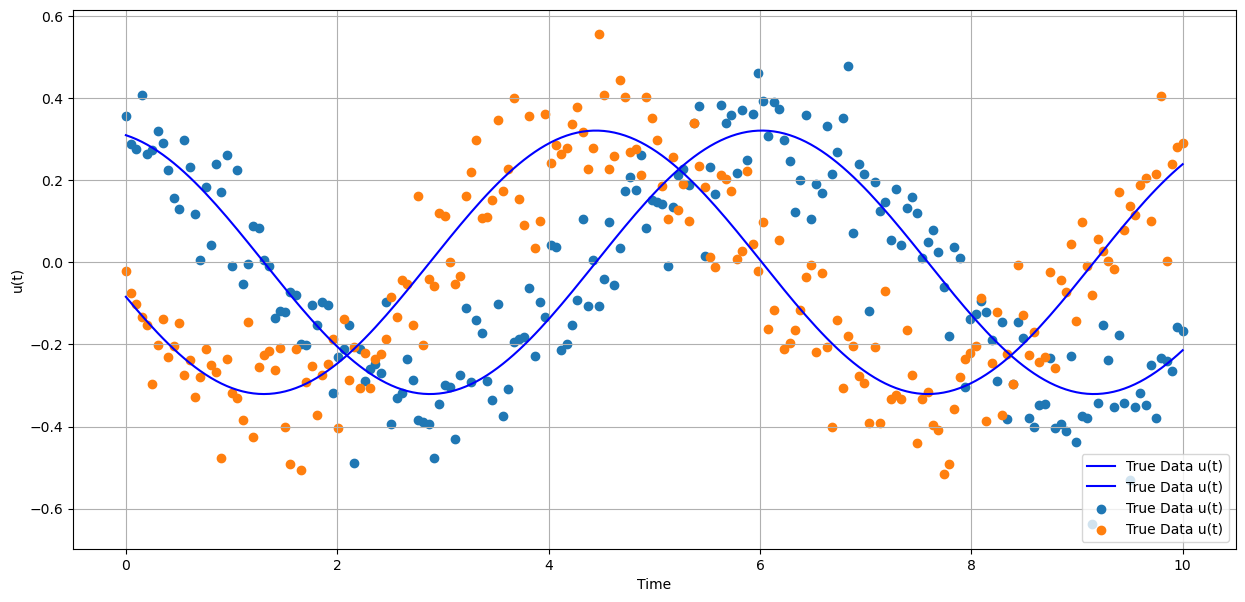

In [108]:
#result = y_pred_results[0]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))

plt.plot(ts, ys, 'b', label='True Data u(t)') 
plt.scatter(ts, ys_noisy.T[0], label='True Data u(t)') 
plt.scatter(ts, ys_noisy.T[1], label='True Data u(t)') 
#plt.scatter(t[:n], u_noisy[:n], label='Observed Data u(t)', alpha=1) 
#plt.scatter(t, u_noisy, label='Observed Data u(t)', alpha=0.5) 

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

Step: 0, Loss: 6.549630055011463, Computation time: 0.6865379810333252
Step: 100, Loss: 7.255272869101086, Computation time: 0.0019600391387939453
Step: 200, Loss: 6.827440647832833, Computation time: 0.0018639564514160156
Step: 300, Loss: 6.679945105307484, Computation time: 0.0018620491027832031
Step: 400, Loss: 6.7090219912909035, Computation time: 0.0019288063049316406
Step: 500, Loss: 7.553299230094936, Computation time: 0.0019829273223876953
Step: 600, Loss: 7.157486021005995, Computation time: 0.002009153366088867
Step: 700, Loss: 6.895590658448889, Computation time: 0.0019109249114990234
Step: 800, Loss: 6.577140017038432, Computation time: 0.0019350051879882812
Step: 900, Loss: 7.102777510732839, Computation time: 0.0018770694732666016
Step: 999, Loss: 6.770453666873126, Computation time: 0.001941680908203125


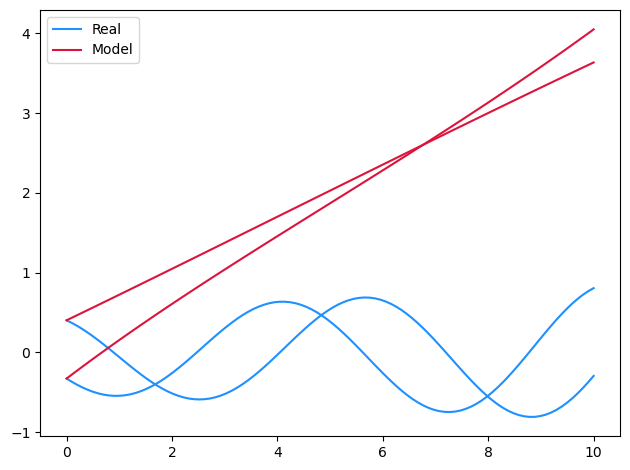

(Array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
         0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
         1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
         1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
         2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
         2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
         3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
         3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
         4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
         4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
         5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
         5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
         6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
         6.56565657,  6.66666667,  6.76767677,  6.8

In [8]:
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

def generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state):
    ts = jnp.linspace(start_time, end_time, N)
    
    def f(t, y):
        if ode_type == 'simple_harmonic':
            omega = params.get('omega', 1.0)
            return jnp.array([y[1], -omega**2 * y[0]])
        else:
            raise ValueError("Unsupported ODE type")

    ys = jnp.zeros((N, len(initial_state)))
    ys = ys.at[0].set(initial_state)
    dt = ts[1] - ts[0]

    for i in range(1, N):
        ys = ys.at[i].set(ys[i-1] + dt * f(ts[i-1], ys[i-1]))

    noise = noise_level * jr.normal(jr.PRNGKey(0), ys.shape)
    ys_noisy = ys + noise

    true_derivatives = jax.vmap(f, in_axes=(0, 0))(ts, ys)

    return ts, ys, ys_noisy, true_derivatives

class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

class NODETrainer:
    def __init__(self, data_size, width_size, depth, lr, steps, batch_size, seed=5678):
        self.key = jr.PRNGKey(seed)
        model_key = jr.split(self.key, 1)[0]
        self.model = NeuralODE(data_size, width_size, depth, key=model_key)
        self.lr = lr
        self.steps = steps
        self.batch_size = batch_size
        self.optimizer = optax.adabelief(self.lr)
        self.opt_state = self.optimizer.init(eqx.filter(self.model, eqx.is_inexact_array))

    def generate_data(self, N, noise_level, ode_type, params, start_time, end_time, spacing_type, dataset_size, key):
        keys = jr.split(key, dataset_size)
        initial_states = jax.vmap(lambda k: jr.uniform(k, (2,), minval=-0.6, maxval=1.0))(keys)
        data = jax.vmap(lambda init_state: generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, init_state))(initial_states)
        ts, ys, ys_noisy, true_derivatives = data
        return ts[0], ys, ys_noisy, true_derivatives

    @eqx.filter_value_and_grad
    def grad_loss(self, model, ti, yi):
        y_pred = jax.vmap(lambda y0: model(ti, y0))(yi[:, 0])
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(self, ti, yi, model, opt_state):
        loss, grads = self.grad_loss(model, ti, yi)
        updates, opt_state = self.optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    def dataloader(self, arrays, batch_size, *, key):
        dataset_size = arrays[0].shape[0]
        assert all(array.shape[0] == dataset_size for array in arrays)
        indices = jnp.arange(dataset_size)
        while True:
            perm = jr.permutation(key, indices)
            (key,) = jr.split(key, 1)
            start = 0
            end = batch_size
            while end <= dataset_size:
                batch_perm = perm[start:end]
                yield tuple(array[batch_perm] for array in arrays)
                start = end
                end = start + batch_size

    def train(self, N, noise_level, ode_type, params, start_time, end_time, spacing_type, dataset_size, print_every=100, plot=True):
        data_key, model_key, loader_key = jr.split(self.key, 3)
        
        ts, ys, ys_noisy, true_derivatives = self.generate_data(
            N, noise_level, ode_type, params, start_time, end_time, spacing_type, dataset_size, key=data_key)
        length_size, data_size = ys.shape[1:]

        _ts = ts
        _ys = ys_noisy

        for step, (yi,) in zip(
            range(self.steps), self.dataloader((_ys,), self.batch_size, key=loader_key)
        ):
            start = time.time()
            loss, self.model, self.opt_state = self.make_step(_ts, yi, self.model, self.opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == self.steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

        if plot:
            plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
            plt.plot(ts, ys[0, :, 1], c="dodgerblue")
            model_y = self.model(ts, ys[0, 0])
            plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
            plt.plot(ts, model_y[:, 1], c="crimson")
            plt.legend()
            plt.tight_layout()
            plt.savefig("neural_ode.png")
            plt.show()

        return ts, ys, self.model

# Example usage
dataset_size = 256
N = 100
noise_level = 0.1
ode_type = 'simple_harmonic'
params = {'omega': 1.0}
start_time = 0.0
end_time = 10.0
spacing_type = 'uniform'

trainer = NODETrainer(data_size=2, width_size=64, depth=2, lr=3e-3, steps=1000, batch_size=32)
trainer.train(N, noise_level, ode_type, params, start_time, end_time, spacing_type, dataset_size)


In [26]:
ts = trainer.generate_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, dataset_size, key=jr.PRNGKey(1))[0]
ys = trainer.generate_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, dataset_size, key=jr.PRNGKey(1))[1]
ys_noisy = trainer.generate_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, dataset_size, key=jr.PRNGKey(1))[2]

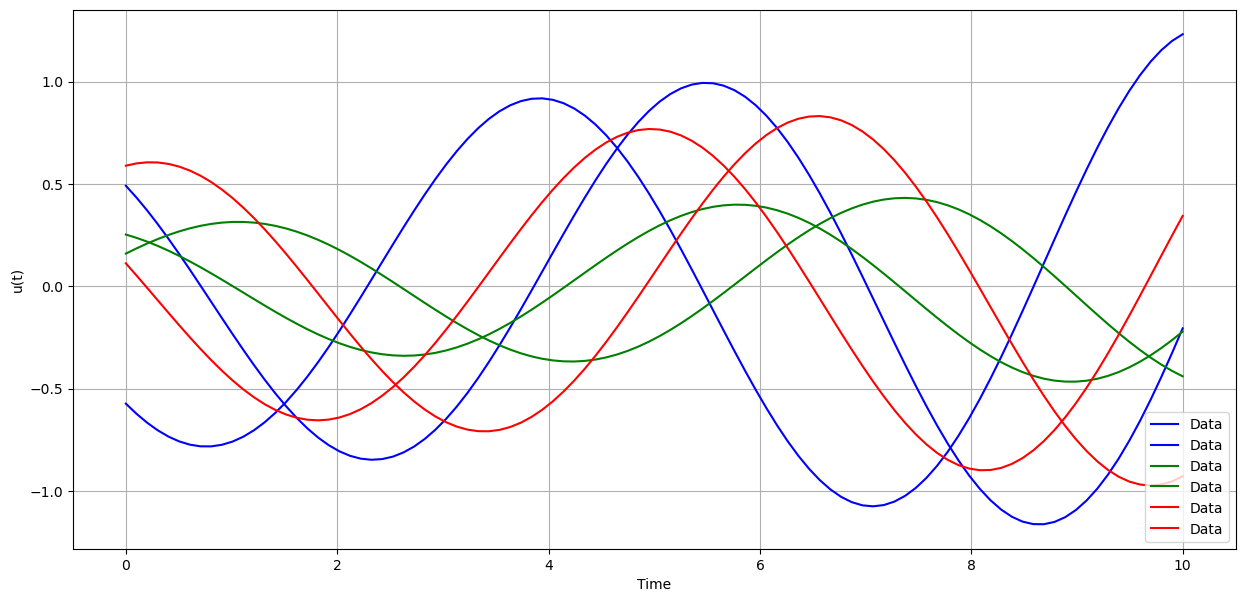

In [27]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(ts, ys[0,:], 'b', label='Data')
plt.plot(ts, ys[1,:], 'g', label='Data')
plt.plot(ts, ys[200,:], 'r', label='Data')

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()